- A sample notebook to convert Jim Thomson's matlab structures into netcdf format
- I tried to make it as general as possible, but can't guarantee it will work for all the different structure types!
- It should be easy enough to convert this into a loop if you want to run it on lots of different files
- Author: Lettie Roach, lroach@uw.edu - last updated Apr 2020
- Edited: Vince Cooper, vcooper@uw.edu - updated Jul 2020 for SODA R0 from S Brenner
- Edited: Vince Cooper, vcooper@uw.edu - Sep 2020 for BGOS-AWAC update from J Thomson

In [1]:
import numpy as np
import matplotlib as mpl
import glob
import os
import matplotlib.pyplot as plt
from scipy.io import savemat,loadmat,whosmat
import pandas as pd
import datetime, time
import xarray as xr

A function to convert matlab datenum to python datetime

In [2]:
def matlab2datetime(matlab_datenum):
    
    if matlab_datenum!=matlab_datenum: #if there is NaN in the time dimension
        mytime = 0 # this sets time to 1970, which we will then screen out below
    else:
        day = datetime.datetime.fromordinal(int(matlab_datenum))
        dayfrac = datetime.timedelta(days=matlab_datenum%1) - datetime.timedelta(days=366)
        mytime = day + dayfrac
    return mytime

Edit these

In [67]:
datadir = '/glade/work/vcooper/BGEP_vtc/BGOS-AWAC_resultsv02/' # stored wave files
os.listdir(datadir)
fname = 'BGOS-D_AWAC.mat'

Read in SWIFT metadata

In [14]:
# df = pd.read_csv('SWIFT_README.csv')
# df = df.set_index('netcdf_var').transpose()
# attr_dict = df.to_dict()

In [68]:
struct = loadmat(datadir+fname,squeeze_me=True)
[f for f in struct]

['__header__', '__version__', '__globals__', 'AWAC']

Read into a pandas dataframe with python datetime format times

In [69]:
identifier = 'AWAC' # check this makes sense with struct above, may need to edit
my_dict = struct[identifier]

In [70]:
my_dict['time'] = [matlab2datetime(tval) for tval in my_dict['time']]
my_dict['time'] = np.array(my_dict['time'],dtype='datetime64[s]')

df = pd.DataFrame(my_dict)
df = df.set_index('time')
len(df.index)

33900

Any NaNs in the time index were set to 1970-01-01, so here we screen them out

In [71]:
df = df.loc[df.index > '2000-01-01']
ntime = len(df.index)
print(ntime)

33900


Read in 1D (dimension=time) directly 

In [72]:
headers = [i for i in df]
headers_1d = [i for i in df if [type(j) for j in df[i]][-1] is not np.ndarray]
df_1d = df[headers_1d]
df_1d

,lat,lon,icethickness,sigwaveheight,peakwaveperiod,peakwavedirT
time,,,,,,
2013-08-09 06:31:01,74,-140,NaN,NaN,NaN,NaN
2013-08-09 07:31:01,74,-140,NaN,NaN,NaN,NaN
2013-08-09 08:31:00,74,-140,NaN,NaN,NaN,NaN
2013-08-09 09:31:01,74,-140,NaN,NaN,NaN,NaN
2013-08-09 10:31:01,74,-140,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...
2018-09-04 07:31:01,74,-140,0.672034,0.964549,4.53097,NaN
2018-09-04 08:31:00,74,-140,0.670812,0.875104,5.38947,NaN
2018-09-04 09:31:01,74,-140,0.686233,0.869093,5.06931,NaN


Possible dimensions the multidimensional data could have - if it is another dimension, you will need to edit

In [73]:
test_dims = ['Nobs','bincenters','freq'] # determined from 'varheaders' below if need to change

In [12]:
## this is how I identified two issue times in BGOS-AWAC-A data
## these are different from the rest of timestamps
## and broke the for loop below
# tflist = []
# for t in range(ntime):
#     tflist = np.append(tflist,
#                         type(df[mult].values[t][()][0]) == type(np.nan))
# print(tflist.sum())

0.0


In [357]:
# tflist[10982:].argmax()
# these are the two problem times, so I can skip them
# print(tflist[10981],
#     tflist[17145+10982])

0.0 0.0


For multidimensional data, loop around and save each variable in a list of Datasets

In [242]:
## ORIGINAL VERSION FROM LETTIE
headers_multd = [h for h in headers if h not in headers_1d]
list_ds = []
print(headers_multd) # e.g. 'wave_spectra' - so here there is only one set of multidimensional data

for mult in headers_multd:
    nvar = len(df[mult].values[0][()]) # number of variables below this heading e.g. 'energy','freq','a1','b1'
    ndim = len(df[mult].values[0][()][0])
    mystr = str(df[mult].values[0][()][()].dtype)
    varheaders = [var[3:-1] for var in mystr.split(',')[::2]]
    print(varheaders)
    multidimdata = np.zeros([nvar,ntime,ndim])
    for t in range(ntime):
        for v in range(nvar):
            multidimdata[v,t,:] = df[mult].values[t][()][v][:]
    
    # identify which of these variables is a dimension
    my_dim = ''
    for f in range(len(test_dims)):
        if test_dims[f] in varheaders:
            my_dim = test_dims[f]
    print(my_dim)
    
    if my_dim !='': # we found the dimension for multidimensional data
        ind_dim = varheaders.index(my_dim)
        varheaders.remove(my_dim)
        my_dim_vals = multidimdata[ind_dim,0,:]
        multidimdata = np.delete(multidimdata,ind_dim,axis=0)
        nvar = nvar - 1
    
    # make a Dataset for the first variable
    ds = xr.Dataset(
            data_vars ={mult+'_'+varheaders[0] : xr.DataArray(multidimdata[0,:,:],dims=['time',my_dim+'_'+mult])},
            coords={'time' : df.index, my_dim+'_'+mult : my_dim_vals})
    
    # if there are more variables, add these to to the Dataset
    if nvar > 1:
        for v in range(1,nvar):
            ds[mult+'_'+varheaders[v]] = xr.DataArray(multidimdata[v,:,:],dims=['time',my_dim+'_'+mult])
    list_ds.append(ds)
       
    print(ds)



['wavespectra']
['energy', 'freq', 'a1', 'b1', 'a2', 'b2', 'check']
freq
<xarray.Dataset>
Dimensions:             (freq_wavespectra: 42, time: 4036)
Coordinates:
  * freq_wavespectra    (freq_wavespectra) float64 0.009766 0.02148 ... 0.4902
  * time                (time) datetime64[ns] 2018-10-09 ... 2019-09-11T22:00:00
Data variables:
    wavespectra_energy  (time, freq_wavespectra) float64 nan nan ... 0.003802
    wavespectra_a1      (time, freq_wavespectra) float64 nan nan nan ... nan nan
    wavespectra_b1      (time, freq_wavespectra) float64 nan nan nan ... nan nan
    wavespectra_a2      (time, freq_wavespectra) float64 nan nan nan ... nan nan
    wavespectra_b2      (time, freq_wavespectra) float64 nan nan nan ... nan nan
    wavespectra_check   (time, freq_wavespectra) float64 nan nan nan ... nan nan


In [74]:
headers_multd = [h for h in headers if h not in headers_1d]
list_ds = []
print(headers_multd) # e.g. 'wave_spectra' - so here there is only one set of multidimensional data

for mult in headers_multd:
    nvar = len(df[mult].values[0][()]) # number of variables below this heading e.g. 'energy','freq','a1','b1'
    ndim = len(df[mult].values[0][()][0])
    mystr = str(df[mult].values[0][()][()].dtype)
    varheaders = [var[3:-1] for var in mystr.split(',')[::2]]
    print(varheaders)
    multidimdata = np.zeros([nvar,ntime,ndim])
    for t in range(ntime):
        for v in range(nvar):
            if (type(df[mult].values[t][()][v]) == float): # these are the errors identified above
                print(t)
                multidimdata[v,t,:] = np.full_like(multidimdata[v,t,:],np.nan) # fill w nan
            else:
                multidimdata[v,t,:] = df[mult].values[t][()][v][:]
    
    # identify which of these variables is a dimension
    my_dim = ''
    for f in range(len(test_dims)):
        if test_dims[f] in varheaders:
            my_dim = test_dims[f]
    print(my_dim)
    
    if my_dim !='': # we found the dimension for multidimensional data
        ind_dim = varheaders.index(my_dim)
        varheaders.remove(my_dim)
        time_avoidnan = np.nanargmax(multidimdata[1,:],axis=0)[0] # get time index with actual dimension vals
        my_dim_vals = multidimdata[ind_dim,time_avoidnan,:]
        multidimdata = np.delete(multidimdata,ind_dim,axis=0)
        nvar = nvar - 1
    
    # make a Dataset for the first variable
    ds = xr.Dataset(
            data_vars ={mult+'_'+varheaders[0] : xr.DataArray(multidimdata[0,:,:],dims=['time',my_dim+'_'+mult])},
            coords={'time' : df.index, my_dim+'_'+mult : my_dim_vals})
    
    # if there are more variables, add these to to the Dataset
    if nvar > 1:
        for v in range(1,nvar):
            ds[mult+'_'+varheaders[v]] = xr.DataArray(multidimdata[v,:,:],dims=['time',my_dim+'_'+mult])
    list_ds.append(ds)
       
    print(ds)

['icehistogram', 'wavespectra']
['Nobs', 'bincenters']
bincenters
<xarray.Dataset>
Dimensions:                  (bincenters_icehistogram: 21, time: 33900)
Coordinates:
  * time                     (time) datetime64[ns] 2013-08-09T06:31:01 ... 2018-09-04T11:31:00
  * bincenters_icehistogram  (bincenters_icehistogram) float64 0.0 0.5 ... 10.0
Data variables:
    icehistogram_Nobs        (time, bincenters_icehistogram) float64 nan ... 0.0
['energy', 'freq']
freq
<xarray.Dataset>
Dimensions:             (freq_wavespectra: 42, time: 33900)
Coordinates:
  * time                (time) datetime64[ns] 2013-08-09T06:31:01 ... 2018-09-04T11:31:00
  * freq_wavespectra    (freq_wavespectra) float64 0.009766 0.02148 ... 0.4902
Data variables:
    wavespectra_energy  (time, freq_wavespectra) float64 nan nan ... 0.01678


Combine everything - 1D plus multidimensional data

In [75]:
list_ds.append(df_1d.to_xarray())
allds = xr.merge(list_ds)   

In [76]:
allds

<xarray.Dataset>
Dimensions:                  (bincenters_icehistogram: 21, freq_wavespectra: 42, time: 33900)
Coordinates:
  * time                     (time) datetime64[ns] 2013-08-09T06:31:01 ... 2018-09-04T11:31:00
  * bincenters_icehistogram  (bincenters_icehistogram) float64 0.0 0.5 ... 10.0
  * freq_wavespectra         (freq_wavespectra) float64 0.009766 ... 0.4902
Data variables:
    icehistogram_Nobs        (time, bincenters_icehistogram) float64 nan ... 0.0
    wavespectra_energy       (time, freq_wavespectra) float64 nan ... 0.01678
    lat                      (time) object 74 74 74 74 74 74 ... 74 74 74 74 74
    lon                      (time) object -140 -140 -140 ... -140 -140 -140
    icethickness             (time) object nan nan nan ... 0.6862 0.6892 0.6823
    sigwaveheight            (time) object nan nan nan ... 0.8691 0.879 0.8117
    peakwaveperiod           (time) object nan nan nan nan ... 5.069 5.389 5.069
    peakwavedirT             (time) object nan nan nan nan ... nan nan nan nan

Add metadata
(pull from SWIFT data)

In [77]:
sodaA = xr.open_dataset('/glade/work/vcooper/BGEP_vtc/SODA/2020-07-27_R0/SODA_A_sigWaves.mat_converted_2020-07-27.nc')
for var in allds:
    print(var, var in sodaA)

icehistogram_Nobs False
wavespectra_energy True
lat True
lon True
icethickness False
sigwaveheight True
peakwaveperiod True
peakwavedirT True


In [78]:
# for the whole file
allds.attrs= {'description' : identifier,
              'data' : 'BGOS-AWAC, Jim Thomson, APL',
              'netcdf_created_by': 'Vince Cooper, 2020, UW',
              'comment': 'Attributes pulled from SWIFT 2015 data'}

# for variables - add description and units
for var in allds:
        if var in sodaA:
#             allds[var].attrs['units'] = attr_dict[var]['units']
#             allds[var].attrs['description'] = attr_dict[var]['description']
            allds[var].attrs = sodaA[var].attrs

allds

<xarray.Dataset>
Dimensions:                  (bincenters_icehistogram: 21, freq_wavespectra: 42, time: 33900)
Coordinates:
  * time                     (time) datetime64[ns] 2013-08-09T06:31:01 ... 2018-09-04T11:31:00
  * bincenters_icehistogram  (bincenters_icehistogram) float64 0.0 0.5 ... 10.0
  * freq_wavespectra         (freq_wavespectra) float64 0.009766 ... 0.4902
Data variables:
    icehistogram_Nobs        (time, bincenters_icehistogram) float64 nan ... 0.0
    wavespectra_energy       (time, freq_wavespectra) float64 nan ... 0.01678
    lat                      (time) object 74 74 74 74 74 74 ... 74 74 74 74 74
    lon                      (time) object -140 -140 -140 ... -140 -140 -140
    icethickness             (time) object nan nan nan ... 0.6862 0.6892 0.6823
    sigwaveheight            (time) object nan nan nan ... 0.8691 0.879 0.8117
    peakwaveperiod           (time) object nan nan nan nan ... 5.069 5.389 5.069
    peakwavedirT             (time) object nan nan nan nan ... nan nan nan nan
Attributes:
    description:        AWAC
    data:               BGOS-AWAC, Jim Thomson, APL
    netcdf_created_by:  Vince Cooper, 2020, UW
    comment:            Attributes pulled from SWIFT 2015 data

Output to netcdf

In [79]:
allds.to_netcdf(fname+'_converted.nc')

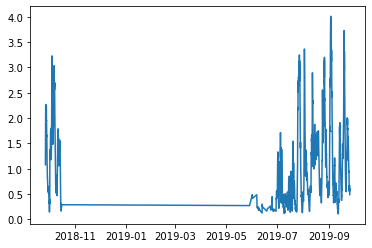

In [23]:
# SODA A
plt.plot(allds.sigwaveheight.time.values,allds.sigwaveheight.values)

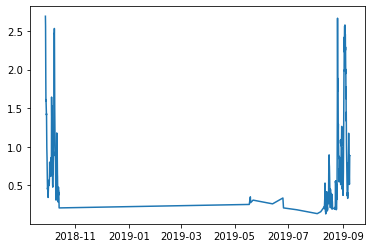

In [21]:
# SODA B
plt.plot(allds.sigwaveheight.time.values,allds.sigwaveheight.values)

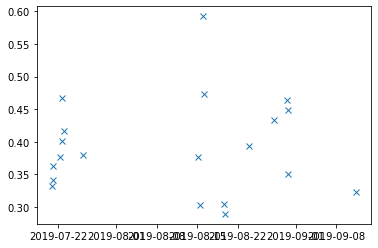

In [38]:
# SODA C
plt.plot(allds.sigwaveheight.time.values,allds.sigwaveheight.values,marker='x',linestyle='')

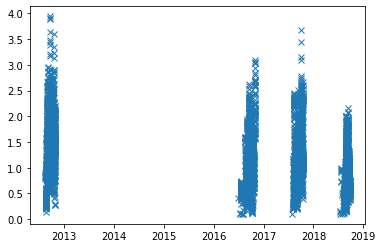

In [60]:
# BGOS-A
plt.plot(allds.sigwaveheight.time.values,allds.sigwaveheight.values,marker='x',linestyle='')

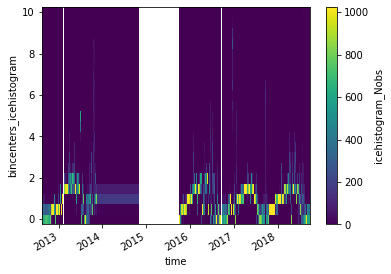

In [64]:
allds.icehistogram_Nobs.T.plot()
plt.show()

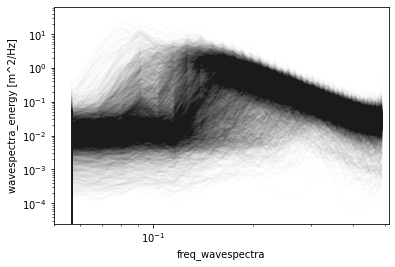

CPU times: user 37.6 s, sys: 581 ms, total: 38.2 s
Wall time: 38.3 s


In [61]:
%%time
allds.wavespectra_energy.plot.line(hue='time',add_legend=False,alpha=0.01,c='0.1')
plt.xlim(0.05,)
plt.loglog()
plt.show()

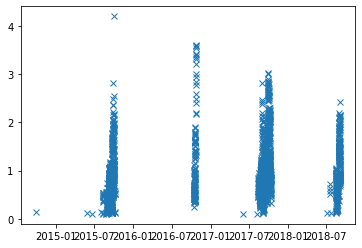

In [80]:
# BGOS-D
plt.plot(allds.sigwaveheight.time.values,allds.sigwaveheight.values,marker='x',linestyle='')

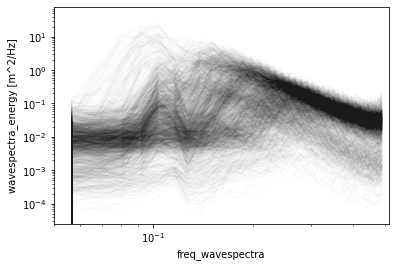

CPU times: user 38.2 s, sys: 517 ms, total: 38.7 s
Wall time: 38.7 s


In [81]:
%%time
allds.wavespectra_energy.plot.line(hue='time',add_legend=False,alpha=0.01,c='0.1')
plt.xlim(0.05,)
plt.loglog()
plt.show()

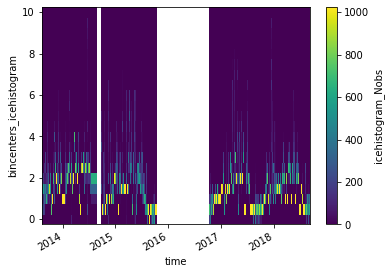

In [82]:
allds.icehistogram_Nobs.T.plot()
plt.show()